In [3]:
current_path='/content/drive/Data/'

# Imports

In [ ]:
pip install hazm

In [5]:
import random
from hazm import *
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Embedding
from keras.layers.core import Dense, Activation
import numpy as np
import matplotlib.pyplot as plt
import heapq
import random
from sklearn.model_selection import train_test_split
import pickle

words_length_embedded = 100
word2index = {}
index2word = {}

# Data preprocessing

First of all we have chosen half of the data from each textfile and saved it to data.txt file.

In [ ]:
with open("sports.txt", "r") as f:
    lines = f.readlines()
count=0
with open(current_path+'data01.txt', "a+",encoding="utf-8") as file_object:
    file_object.seek(0)
    data = file_object.read(100)
    if len(data) > 0 :
        file_object.write("\n")
    for line in lines:
        if random.uniform(0.0,1.0)<0.1:
          count+=1
          file_object.write(line)
print(count)

183161


In [ ]:
#number of lines of data
with open(current_path+'data015.txt', "r",encoding="utf-8") as file_object:
    data = file_object.read()
# print(len(data.split('\n')))

In [ ]:
#random lines to check
for x in random.sample(data.split('\n'), 30):
    print(x)

انوش دستگیر 29 ساله جوان ترین مربی در بین 211 تیم ملی است که برای صعود به جام جهانی قطر تلاش می کنند. او از سال گذشته هدایت افغان ها را برعهده دارد.


گوشت سردست گوساله نيز با كيلويي هشت هزار تومان تا 10 هزار و 500 تومان عرضه مي‌شود و گران‌ترين نوع گوشت ران و ماهيچه گوسفند است كه به ترتيب با كيلويي 17 هزار و 800 و 18 هزار و 500 تومان عرضه مي‌شود.
وی در ابتدای صحبت‌هایش گفت: شنیده‌ام که فدراسیون با هر گزینه‌ای مذاکره می‌کند، در این بین کی‌روش سنگ‌اندازی‌هایی انجام می‌دهد. البته من فقط این موضوع را چون بر سر زبان‌ها افتاده شنیده‌ام، اما حالا این کارها را باید آقایانی جواب بدهند که سنگ کی‌روش را به سینه می‌زدند. این مربی زمانی مشتش را به سمت نیمکت تیم ملی کره نشان داد و چند هفته پیش از آنها عذرخواهی کرد. یا مرتب می‌گفت ایران در قلب من است اما حالا از فدراسیون فوتبال شکایت کرده است. نمی‌دانم این چه رابطه‌ای بود که یک مربی ۸ سال در ایران حضور داشت و بلافاصله بعد از جدایی از فدراسیون شکایت کرد و از آن طرف مسئولان فدراسیون هم حالا می‌خواهند از او شکایت کنند.
در زمان تحویل طرح توسعه میدان آزاد

In [6]:
characters = ['ض', 'ص', 'ث', 'ق', 'ف', 'غ', 'ع', 'ه', 'خ', 'ح', 'ج', 'چ', 'پ', 'ش', 'س', 'ی', 'ب', 'ل', 'أ' ,'ا', 'آ', 'ت',
              'ن', 'م', 'ک', 'گ', 'ظ', 'ط', 'ز', 'ر', 'ژ', 'ذ', 'د', 'ئ', 'ء', 'و', 'إ', 'ؤ', 'ي', 'ة', '۱', '۲', '۳', '۴', '۵',
              '۶', '۷', '۸', '۹', '۰', ' ']
persian_numbers = ['\u06F0', '\u06F1', '\u06F2', '\u06F3', '\u06F4', '\u06F5', '\u06F6', '\u06F7', '\u06F8', '\u06F9']

number_of_previous_words = 4

In [7]:
def replace_arabic_chars(text):
    text = text.replace('\u0660', '\u06F0').replace('\u0661', '\u06F1').replace('\u0662', '\u06F2').replace('\u0663', '\u06F3').replace('\u0664', '\u06F4').replace('\u0665', '۵\u06F5').replace('\u0666', '\u06F6').replace('\u0667', '\u06F7').replace('\u0668', '\u06F8').replace('\u0669', '\u06F9')  # arabic number to persian number
    text = text.replace('\u0643', '\u06A9').replace('u\0649', '\u06CC').replace('\u064A', '\u06CC').replace('\u06D5', '\u0647')  # "ك" to "ک", "ى" to "ی", "ي" to "ی" , "ە" to "ه"
    return text

def replace_english_chars(text):
    text = text.replace('0', '۰').replace('1', '۱').replace('2', '۲').replace('3', '۳').replace('4', '۴').replace('5', '۵').replace('6', '۶').replace('7', '۷').replace('8', '۸').replace('9', '۹')  # non-breaking space
    text = text.replace(';', '؛').replace('?', '؟').replace(',', '،')
    return text
    
def replace_other_chars(text):
    text = text.replace('\n', '').replace('\u200c', ' ').replace('\xa0', ' ')  # non-breaking space
    return text

def clean_text(text):
    new_chars = set(text) - set(characters)
    has_new_char = False
    for char in new_chars:
        text = text.replace(char, '')
        has_new_char = True
    return text, has_new_char

In [ ]:
# testing !
import resource 
def read_data(path,limit):
    f = open(path, 'r', encoding='UTF-8')
    lines = f.readlines()[:limit]
    previous_words = []
    next_words = []
    unique_words = set()

    for ii, line in enumerate(lines):
        if ii%100000==0:
            print(f"current memory usage: {resource.getrusage(resource.RUSAGE_SELF).ru_maxrss}")
        line = replace_arabic_chars(line)
        line = replace_english_chars(line)
        line = replace_other_chars(line)
        line, _ = clean_text(line)
        words = line.split()
        if len(words) < number_of_previous_words+1:
            continue
        for i in range(len(words)-number_of_previous_words):
            previous_words.append(words[i: i+number_of_previous_words])
            next_words.append(words[i+number_of_previous_words])
            unique_words.update(set(words))
    return previous_words, next_words, list(unique_words)

In [ ]:
def save_data(data, path):
    f = open(current_path + path, 'wb')  
    pickle.dump(data, f)
    f.close()

In [ ]:
# Exmaple of results of "read_data" function
previous_worsds, next_words, unique_words = read_data(current_path + 'data01.txt',5000)
save_data(previous_worsds, './previous_words.p')
save_data(next_words, './next_words.p')
save_data(unique_words, './unique_words.p')
previous_worsds=[]
next_words=[]
unique_words=[]

current memory usage: 759756


In [8]:
def word_indexing(unique_words):
    word2index = dict((c, i+1) for i, c in enumerate(unique_words))
    word2index['PAD'] = 0
    index2word = dict((i+1, c) for i, c in enumerate(unique_words))
    index2word[0] = 'PAD'
    return word2index, index2word
with open(current_path + './unique_words.p', 'rb') as f:
        unique_words = pickle.load(f)
word2index, index2word = word_indexing(unique_words)

In [ ]:
def create_train_test_data(previous_worsds, next_words):
    data_train, data_test, labels_train, labels_test = train_test_split(previous_worsds, next_words, test_size=0.05)
    return data_train, data_test, labels_train, labels_test

with open(current_path + './previous_words.p', 'rb') as f:
        previous_worsds = pickle.load(f)
with open(current_path + './next_words.p', 'rb') as f:
        next_words = pickle.load(f)
data_train, data_test, labels_train, labels_test = create_train_test_data(previous_worsds, next_words)

In [ ]:
def create_matrices(previous_worsds, next_words, word2index, data_path, label_path):
    data = np.zeros((len(previous_worsds), number_of_previous_words), dtype=int)
    labels = np.zeros((len(next_words), 1), dtype=int)
    for i, words_list in enumerate(previous_worsds):
        for j, word in enumerate(words_list):
            data[i, j] =  word2index[word]
        labels[i] = word2index[next_words[i]]

    save_data(data, data_path)
    save_data(labels, label_path)

create_matrices(data_train, labels_train, word2index, './data_train.p', './labels_train.p')
create_matrices(data_test, labels_test, word2index, './data_test.p', './labels_test.p')
parameters = {'number_of_previous_words': number_of_previous_words, 'persian_numbers': persian_numbers, 'characters': characters}
save_data(parameters, './parameters.p')
save_data(word2index, './word2index.p')
save_data(index2word, './index2word.p')

In [9]:
def set_parameters(path):
    f = open(current_path + path, 'rb') 
    parameters = pickle.load(f)
    f.close()
    number_of_previous_words = parameters['number_of_previous_words']
    return number_of_previous_words
number_of_previous_words = set_parameters('./parameters.p')

In [10]:
def load_words_from_file():
    with open(current_path + './data_train.p', 'rb') as f:
        train_data = pickle.load(f)

    with open(current_path + './labels_train.p', 'rb') as f:
        train_labels = pickle.load(f)
        
    with open(current_path + './word2index.p', 'rb') as f:
        word2index = pickle.load(f)

    with open(current_path + './index2word.p', 'rb') as f:
        index2word = pickle.load(f)
    return train_data, train_labels, word2index, index2word

train_data, train_labels, word2index, index2word = load_words_from_file()

# Build the model

In [18]:
words_length_embedded=5000

In [19]:
model = Sequential()
model.add(Embedding(len(word2index), words_length_embedded, input_length=number_of_previous_words))
model.add(LSTM(512, input_shape=(number_of_previous_words, words_length_embedded), return_sequences=True))
model.add(LSTM(512, return_sequences=False))
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Dense(len(word2index)))
model.add(Activation('softmax'))
optimizer = 'adam'
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 4, 5000)           90525000  
                                                                 
 lstm_2 (LSTM)               (None, 4, 512)            11290624  
                                                                 
 lstm_3 (LSTM)               (None, 512)               2099200   
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 18105)             2335545   
                                                                 
 activation_1 (Activation)   (None, 18105)            

In [ ]:
history = model.fit(train_data, train_labels, validation_split=0.2, batch_size=512, epochs=1, shuffle=True)
model.save(current_path + 'model/model_1st.h5')

706/706 [==============================] - 3563s 5s/step - loss: 6.6702 - accuracy: 0.0745 - val_loss: 6.3122 - val_accuracy: 0.1080


In [20]:
model.load_weights(current_path + 'model/model_1st.h5')

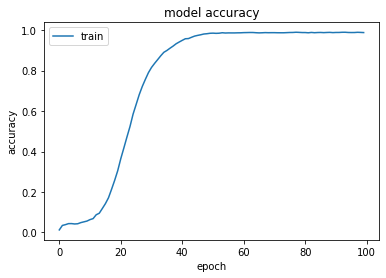

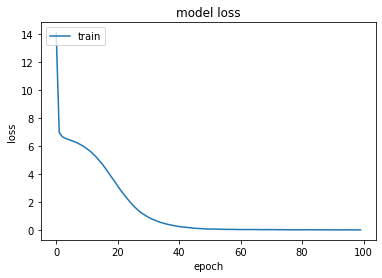

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [12]:

def prepare_input(text):
    """
      This function makes related vector of input text to  use it in model
    """
    text = text.split()[-number_of_previous_words:]  # get n last words of text
    text = ' '.join(text)
    text = replace_arabic_chars(text)
    text = replace_english_chars(text)
    text = replace_other_chars(text)
    text, _ = clean_text(text)
    input_vector = np.zeros((1, number_of_previous_words), dtype=int)
    words = text.split()
    for t, word in enumerate(words):   #  add index of input text to end of vector
        try:
          input_vector[0, t + (number_of_previous_words - len(words))] = word2index[word]
        except:
          print('')
    return input_vector

In [13]:
def sample(preds, top_n=3):
    """
      This function selecte n best predections of model
    """
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    res_index = heapq.nlargest(top_n, range(len(preds)), preds.take)
    res_prob = [preds[i] for i in res_index]
    return [res_index, res_prob]

In [14]:
def predict_completions(text, n=100):
    """
      This function uses tow previous functions to predict n best word as next word for input text
    """
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    result = sample(preds, n)
    next_indices = result[0]
    return [index2word[idx] for idx in next_indices]

In [24]:
test =  input()
next_word = predict_completions(test, 1000)
print('input text: ' + test)
print('next word: ' + str(next_word))

اعتراف کونته: چلسی خیلی از ما بهتر بود‎
input text: اعتراف کونته: چلسی خیلی از ما بهتر بود‎
next word: ['و', 'که', 'در', 'به', 'اما', 'این', 'تا', 'با', 'او', 'از', 'اگر', 'برای', 'یا', 'گفت', 'می', 'بنابراین', 'بر', 'باید', 'بلکه', 'ما', 'است', 'یعنی', 'دولت', 'البته', 'چرا', 'چون', 'درباره', 'زیرا', 'وقتی', 'یک', 'هر', 'رئیس', 'مثلا', 'پس', 'ولی', 'نه', 'آن', 'هم', 'را', 'آیا', 'حتی', 'برخی', 'بانک', 'یکی', 'افزایش', 'شما', 'نیز', 'من', 'شاید', 'همچنین', 'تصریح', 'قرار', 'افزود', 'وی', 'ایران', 'مگر', 'نمی', 'شاهد', 'انجام', 'پیش', 'همه', 'بعد', 'چراکه', 'اینکه', 'حدود', 'فقط', 'تنها', 'ادامه', 'بیش', 'هیچ', 'همان', 'مانند', 'متأسفانه', 'دیگر', 'طبق', 'تأکید', 'سازمان', 'چه', 'خود', 'همین', 'ضمن', 'براساس', 'هرچند', 'اظهار', 'آقای', 'حالا', 'آنها', 'مردم', 'ایجاد', 'وجود', 'ممکن', 'قیمت', 'بخشی', 'هزینه', 'اشاره', 'اگرچه', 'کرد', 'مبنی', 'علاوه', 'مثل', 'وزیر', 'بسیاری', 'نشان', 'اینها', 'مشخص', 'بودجه', 'وزارت', 'پاسخ', 'انتظار', 'روی', 'مقرر', 'بررسی', 'گزارش', 'اول', 'حضور', 'نکته

In [ ]:
test =  input()
next_word = predict_completions(test, 1000)
print('input text: ' + test)
print('next word: ' + str(next_word))

بحران آب
input text: بحران آب
next word: ['و', 'را', 'در', 'به', 'های', 'ها', 'است', 'ای', 'از', 'برای', 'که', 'با', 'نیز', 'یا', 'تا', 'کشور', 'ایران', 'می', 'خود', 'باشد', 'دارد', 'ملی', 'هم', 'بوده', 'دلار', 'هستند', 'گذاری', 'نفت', 'تومان', 'شده', 'انجام', 'اقتصادی', 'مسکن', 'مالی', 'بسیار', 'بر', 'نیست', 'داشته', 'دارند', 'بود', 'این', 'سرمایه', 'داخلی', 'سازی', 'میلیارد', 'هایی', 'قرار', 'درصد', 'واحد', 'آزاد', 'جدید', 'توسعه', 'دولت', 'بزرگ', 'آب', 'اجتماعی', 'آن', 'هزار', 'درباره', 'افزایش', 'تولید', 'تر', 'بین', 'باید', 'بنزین', 'ارز', 'ایجاد', 'کرده', 'اش', 'ندارد', 'مردم', 'پیش', 'آمریکا', 'برق', 'جهانی', 'شناسی', 'ما', 'خودرو', 'کشاورزی', 'ونقل', 'خواهد', 'خارجی', 'مالیاتی', 'بازار', 'مورد', 'وزارت', 'میلیون', 'آنها', 'باشند', 'دولتی', 'تن', 'بی', 'کالا', 'کاهش', 'بانک', 'تجارت', 'سهام', 'تعیین', 'پول', 'نشان', 'بدون', 'داری', 'گفت', 'دیده', 'عمومی', 'اما', 'شان', 'بندی', 'فولاد', 'خصوصی', 'اند', 'نمی', 'بودجه', 'فراهم', 'قابل', 'سیاسی', 'اساسی', 'بیشتر', 'دیگر', 'نفتی', 'ی

In [16]:
def checkIntegrity(format,word):
  return word.startswith(format)
def nBestMatch(sortedList,format,N=5):
  results = []
  for word in sortedList:
    if(checkIntegrity(format,word)):
      results.append(word)
    if len(results) == 5:
      return results
  return results

In [25]:
test =  input()
next_word = predict_completions(test, 1000)
print('input text: ' + test)
print('next word: ',nBestMatch(next_word,"بو"))

اعتراف کونته: چلسی خیلی از ما بهتر
input text: اعتراف کونته: چلسی خیلی از ما بهتر
next word:  ['بود', 'بودند', 'بوده', 'بودیم', 'بودن']
